# Federated Learning with Pytorch Backend

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.

In this tutorial, We will walk you through how to use pytorch backend on SecretFlow for federated learning.  

+ We will use the image clasification task as example
+ Use pytorch as backend
+ We will show how to use multi fl strategy
  
If you want to learn more about federated learning, datasets, etc., you can move to [Federated Learning for Image Classification](Federate_Learning_for_Image_Classification.ipynb).
  
**Here we go!**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

2022-08-31 23:43:03.362818: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib


### Here, let us first introduce some concepts
BaseModule: Similar to the `torch.nn.module`.    
TorchModel: A wrap class include `loss_fn`,`optim_fn`,`model_def`,`metrics`.  
metric_wrapper: Wrap metrics to workers.  
optim_wrapper: Wrap optim_fn to workers.  
FLModel: Federated model, use `backend` to specify which backend will be use, use `strategy` to spcify which federated strategy will be use.

In [3]:
from secretflow_fl.ml.nn.core.torch import (
    metric_wrapper,
    optim_wrapper,
    BaseModule,
    TorchModel,
)
from secretflow_fl.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow_fl.utils.simulation.datasets_fl import load_mnist
from torch import nn, optim
from torch.nn import functional as F

When we define the model, we only need to inherit `BaseModule` instead of `nn.Module`, and the others are consistent with pytorch.

In [4]:
class ConvNet(BaseModule):
    """Small ConvNet for MNIST."""

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc_in_dim = 192
        self.fc = nn.Linear(self.fc_in_dim, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.fc_in_dim)
        x = self.fc(x)
        return F.softmax(x, dim=1)

We can continue to use the loss function and optimizer defined in pytorch, the only difference is that we need to wrap it with the wrapper provided in secretflow.

In [5]:
(train_data, train_label), (test_data, test_label) = load_mnist(
    parts={alice: 0.4, bob: 0.6},
    normalized_x=True,
    categorical_y=True,
    is_torch=True,
)

loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)
model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)

In [6]:
device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)

In [7]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=32,
    aggregate_freq=1,
)

100%|█████████▉| 749/750 [00:15<00:00, 47.41it/s]2022-08-31 23:43:34.759168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
2022-08-31 23:43:34.759205: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
100%|██████████| 125/125 [00:03<00:00, 41.34it/s, epoch: 20/20 -  accuracy:0.9922599792480469  precision:0.9637500047683716  val_accuracy:0.9883599877357483  val_precision:0.922249972820282 ]


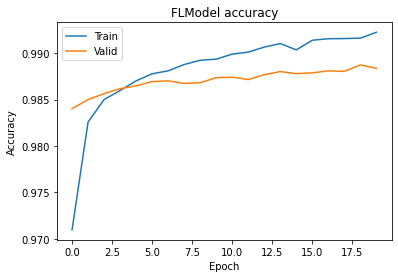

In [8]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]['multiclassaccuracy'])
plt.plot(history["global_history"]['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()